**IMPORTING NECESSARY LIBRARIES**

In [128]:
!pip install preprocessor

In [129]:
!pip install tensorflow


In [130]:
import os
import pandas as pd
import tweepy
import re
import string
import nltk
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('punkt_tab')
from textblob import TextBlob
import preprocessor as p
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import pandas as pd
from nltk.tokenize import word_tokenize
from string import punctuation
from nltk.corpus import stopwords
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Embedding, SimpleRNN,Input
from tensorflow.keras.models import Sequential,Model
from tensorflow.keras.preprocessing import sequence
from tensorflow.keras.layers import Dense,Dropout
from tensorflow.keras.layers import Embedding, Flatten, Dense,Conv1D,MaxPooling1D
from sklearn import preprocessing
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import itertools
import seaborn as sns
from sklearn.metrics import confusion_matrix
from tensorflow.keras.utils import to_categorical
from collections import Counter
import tensorflow as tf
from tensorflow.keras.layers import LSTM, Bidirectional, Dropout

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


### **LOAD RAW DATA**

In [131]:
congress_df = pd.read_csv("/content/Congress_data.csv")
bjp_df = pd.read_csv("/content/BJP_data.csv")

### **DATA CLEANING**


In [132]:
# Happy Emoticons
emoticons_happy = set([
    ':-)', ':)', ';)', ':o)', ':]', ':3', ':c)', ':>', '=]', '8)', '=)', ':}',
    ':^)', ':-D', ':D', '8-D', '8D', 'x-D', 'xD', 'X-D', 'XD', '=-D', '=D',
    '=-3', '=3', ':-))', ":'-)", ":')", ':*', ':^*', '>:P', ':-P', ':P', 'X-P',
    'x-p', 'xp', 'XP', ':-p', ':p', '=p', ':-b', ':b', '>:)', '>;)', '>:-)',
    '<3'
])
# Sad Emoticons
emoticons_sad = set([
    ':L', ':-/', '>:/', ':S', '>:[', ':@', ':-(', ':[', ':-||', '=L', ':<',
    ':-[', ':-<', '=\\', '=/', '>:(', ':(', '>.<', ":'-(", ":'(", ':\\', ':-c',
    ':c', ':{', '>:\\', ';('
])
# Combine emoticons
emoticons = emoticons_happy.union(emoticons_sad)


emoji_pattern = re.compile("["
    u"\U0001F600-\U0001F64F"  # emoticons
    u"\U0001F300-\U0001F5FF"  # symbols & pictographs
    u"\U0001F680-\U0001F6FF"  # transport & map symbols
    u"\U0001F1E0-\U0001F1FF"  # flags
    u"\U00002702-\U000027B0"
    u"\U000024C2-\U0001F251"
"]+", flags=re.UNICODE)

def clean_tweets(tweet):
    stop_words = set(stopwords.words('english')) #this is where we use nltk
    word_tokens = word_tokenize(tweet) #nltk used again for tokenisation

    tweet = re.sub(r':', '', tweet)
    tweet = re.sub(r'‚Ä¶', '', tweet)
    tweet = re.sub(r'[^\x00-\x7F]+',' ', tweet)
    tweet = emoji_pattern.sub(r'', tweet)

    filtered_tweet = []
    for w in word_tokens:
        if w not in stop_words and w not in emoticons and w not in string.punctuation:
            filtered_tweet.append(w)
    return ' '.join(filtered_tweet)

 NLTK - Natural Language Toolkit (python library) is used for working with text data and here used for tokenization (converting the tweets into words) and for removing stopwords.The clean_tweets() funtion after tokenizing the tweet into words loops through each word and if the word is not a stopword ,an emoticon or a punctuation then it is kept in the cleaned tweet. Make the data more precise which is earier to process and improves accuracy.


### **ADDING POLARITY AND SUBJECTIVITY (SENTIMENT)**

In [133]:
def process_existing_csv(file_path, output_path):
    df = pd.read_csv(file_path)
    df['cleaned_text'] = df['original_text'].apply(lambda x: clean_tweets(str(x)))
    df['sentiment'] = df['cleaned_text'].apply(lambda x: TextBlob(x).sentiment) #use of TextBlob
    df['polarity'] = df['sentiment'].apply(lambda x: x.polarity)
    df['subjectivity'] = df['sentiment'].apply(lambda x: x.subjectivity)
    df.to_csv(output_path, index=False, encoding='utf-8')
    print(f"Processed file saved to {output_path}")

# Input and output paths
process_existing_csv('/content/BJP_data.csv', 'bjp_data_processed.csv')
process_existing_csv('/content/Congress_data.csv', 'congress_data_processed.csv')

Processed file saved to bjp_data_processed.csv
Processed file saved to congress_data_processed.csv


TextBlob is used to perform sentiment analysis on the cleaned tweets. It gives you two key values:
*  polarity: ranges from -1 (negative) to 1 (positive).
*  subjectivity: ranges from 0 (objective) to 1 (subjective).





### **LABELING TWEETS AS POSITIVE NEGATIVE**

The TextBlob libary gives out sentiment polarity in the range of -1 to +1. For our topic of election prediction the neutral tweets would be of no or minimal us as they will not provide any valuable information. Thus for simplicity purpose we have labeled tweets as only positive and negative. Tweets with polarity less than 0 will be labelled negative(0) and greater than 0 will be positive(1)

In [134]:
congress_p_df = pd.read_csv("/content/congress_data_processed.csv")
bjp_p_df = pd.read_csv("/content/bjp_data_processed.csv")


congress_p_df ['polarity'] = congress_p_df['polarity'].apply(lambda x: 1 if x > 0 else 0)
bjp_p_df['polarity'] = bjp_p_df['polarity'].apply(lambda x: 1 if x > 0 else 0)

In [135]:
congress_p_df['polarity'].value_counts()

,count
polarity,
0,4132
1,1676


In [136]:
bjp_p_df['polarity'].value_counts()

,count
polarity,
0,1655
1,613


### **ADJUSTING THE DATASET**


Since the ratio of the negative tweets to positive tweets is not proportional. Our data set is not balanced. This will create a bias while training the model. To avoid this we have resampled the data.

In [137]:
congress_df_jan = pd.read_csv('/content/Congress_data_jan.csv')
bjp_df_jan = pd.read_csv('/content/BJP_data_jan.csv') #adding extra datas

In [138]:
bjp_df_jan = bjp_df_jan[['id','clean_text','polarity','place']]
congress_df_jan = congress_df_jan[['id','clean_text','polarity','place']]

In [139]:
bjp_df_jan['polarity'] = bjp_df_jan['polarity'].apply(lambda x: 1 if x > 0 else 0)
congress_df_jan['polarity'] = congress_df_jan['polarity'].apply(lambda x: 1 if x > 0 else 0)

<ipython-input-139-10b9057bafb3>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  congress_df_jan['polarity'] = congress_df_jan['polarity'].apply(lambda x: 1 if x > 0 else 0)


In [140]:
bjp_df_jan['polarity'].value_counts()

,count
polarity,
0,1303
1,853


In [141]:
congress_df_jan['polarity'].value_counts()

,count
polarity,
0,857
1,352


To balance out our earlier dataset we only need to add the positive values from this new dataset so we will be picking out the positve tweets and adding them to out main data set

In [142]:
bjp_df_jan =bjp_df_jan.loc[bjp_df_jan['polarity'] == 1]
congress_df_jan =congress_df_jan.loc[congress_df_jan['polarity'] == 1]

In [143]:
bjp = pd.concat([bjp_p_df, bjp_df_jan], ignore_index=True)
congress = pd.concat([congress_p_df, congress_df_jan], ignore_index=True)

In [144]:
bjp['polarity'].value_counts()


,count
polarity,
0,1655
1,1466


In [145]:
congress['polarity'].value_counts()


,count
polarity,
0,4132
1,2028


In [146]:
bjp.to_csv('bjp_final.csv',index= False)
congress.to_csv('congress_final.csv', index = False)

In [147]:
frames = [bjp, congress]
election_data = pd.concat(frames)

In [148]:
election_data.to_csv('election.csv',index=False) #combiningg both the datesets into into single csv file
print(election_data.columns)

Index(['id', 'created_at', 'source', 'original_text', 'lang', 'favorite_count',
       'retweet_count', 'original_author', 'possibly_sensitive', 'hashtags',
       'user_mentions', 'place', 'cleaned_text', 'sentiment', 'polarity',
       'subjectivity', 'clean_text'],
      dtype='object')


In [149]:
election_data.head()


,id,created_at,source,original_text,lang,favorite_count,retweet_count,original_author,possibly_sensitive,hashtags,user_mentions,place,cleaned_text,sentiment,polarity,subjectivity,clean_text
0,1118010000000000000.0,Tue Apr 16 04:27:15 +0000 2019,"<a href=""http://twitter.com"" rel=""nofollow"">Tw...",@smitabarooah @ModiOnceMore This video show ho...,en,0.0,0.0,wanderlust_hims,NaN,"Modi, Government, effective, works","smitabarooah, ModiOnceMore",Twitter,smitabarooah ModiOnceMore This video show Modi...,"Sentiment(polarity=0.6, subjectivity=0.8)",1,0.80,NaN
1,1118010000000000000.0,Tue Apr 16 04:27:08 +0000 2019,"<a href=""http://twitter.com/download/android"" ...",RT @NandiniOza: A day after his sister n fathe...,en,0.0,1.0,RajeevS27545206,NaN,"Congress, BJP","NandiniOza, imjadeja, narendramodi","Delhi, India",RT NandiniOza A day sister n father joined Con...,"Sentiment(polarity=0.0, subjectivity=0.0)",0,0.00,NaN
2,1118010000000000000.0,Tue Apr 16 04:26:58 +0000 2019,"<a href=""http://twitter.com/download/android"" ...",RT @dpradhanbjp: Glimpses of the massive gathe...,en,0.0,866.0,Anushka97223405,NaN,"BJP, VijaySankalpYatra",dpradhanbjp,NaN,RT dpradhanbjp Glimpses massive gathering supp...,"Sentiment(polarity=0.0, subjectivity=1.0)",0,1.00,NaN
3,1118010000000000000.0,Tue Apr 16 04:26:52 +0000 2019,"<a href=""http://twitter.com/download/iphone"" r...",RT @JhaSanjay: Dear @ArvindKejriwal Ji: Let’s ...,en,0.0,648.0,YasminKidwai,NaN,BJP,"JhaSanjay, ArvindKejriwal",New Delhi,RT JhaSanjay Dear ArvindKejriwal Ji Let ’ clea...,"Sentiment(polarity=0.18333333333333335, subjec...",1,0.85,NaN
4,1118010000000000000.0,Tue Apr 16 04:26:39 +0000 2019,"<a href=""http://twitter.com/download/android"" ...",@kavitavkhanna @VinodKhanna @BJP4India @PMOInd...,en,0.0,0.0,vineetypmehta,NaN,BJP,"kavitavkhanna, VinodKhanna, BJP4India, PMOIndi...",India,kavitavkhanna VinodKhanna BJP4India PMOIndia n...,"Sentiment(polarity=0.0, subjectivity=0.0)",0,0.00,NaN


So far we have collected the dat , cleaned the data to make it earier to process.Established sentiment using polarity and subjectivity.Removed all the neutrel tweets from our dataset and resampled our data to remove bias.Then combined the two datasets of BJP and CONGRESS data into a single data file(election.csv)

### **Visualising Our Dataset**

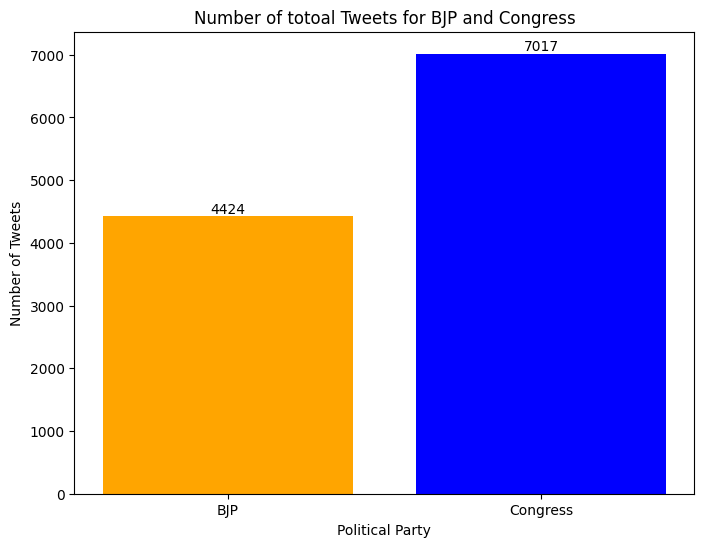

In [150]:
bjp_data = pd.read_csv('/content/BJP_data.csv')
bjp_data_jan = pd.read_csv('/content/BJP_data_jan.csv')
combined_bjp_data = pd.concat([bjp_data, bjp_data_jan], ignore_index=True)

congress_data = pd.read_csv('/content/Congress_data.csv')
congress_data_jan = pd.read_csv('/content/Congress_data_jan.csv')
combined_congress_data = pd.concat([congress_data, congress_data_jan], ignore_index=True)

bjp_tweet_count = len(combined_bjp_data)
congress_tweet_count = len(combined_congress_data)

parties = ['BJP', 'Congress']
tweet_counts = [bjp_tweet_count, congress_tweet_count]

plt.figure(figsize=(8, 6))
plt.bar(parties, tweet_counts, color=['orange', 'blue'])
plt.xlabel('Political Party')
plt.ylabel('Number of Tweets')
plt.title('Number of totoal Tweets for BJP and Congress')

for i, count in enumerate(tweet_counts):
    plt.text(i, count, str(count), ha='center', va='bottom')

plt.show()


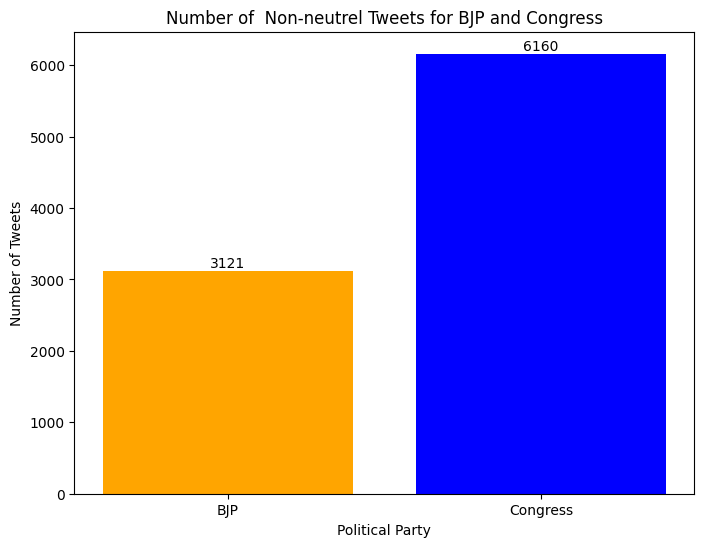

In [151]:
bjp_df = pd.read_csv('/content/bjp_final.csv')
congress_df = pd.read_csv('/content/congress_final.csv')


bjp_tweet_count = len(bjp_df)
congress_tweet_count = len(congress_df)

parties = ['BJP', 'Congress']
tweet_counts = [bjp_tweet_count, congress_tweet_count]

plt.figure(figsize=(8, 6))
plt.bar(parties, tweet_counts, color=['orange', 'blue'])
plt.xlabel('Political Party')
plt.ylabel('Number of Tweets')
plt.title('Number of  Non-neutrel Tweets for BJP and Congress')

for i, count in enumerate(tweet_counts):
    plt.text(i, count, str(count), ha='center', va='bottom')

plt.show()


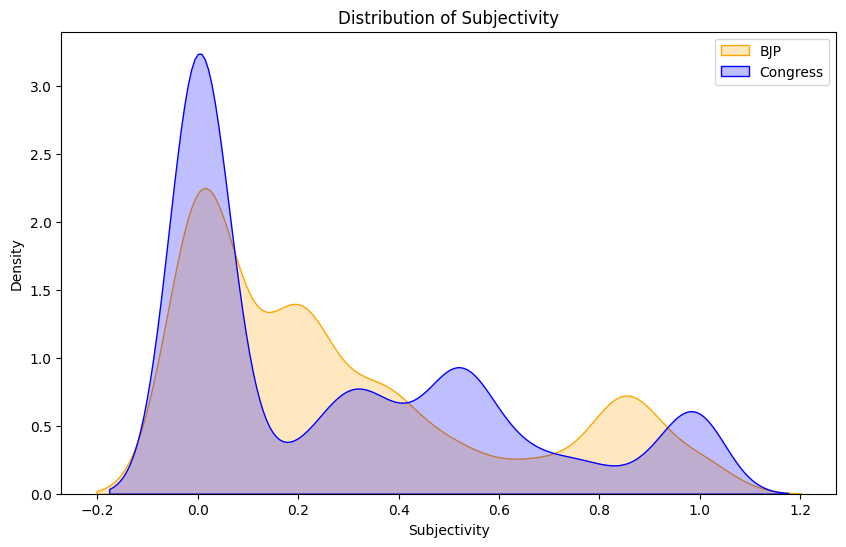

In [152]:
bjp_df = pd.read_csv('/content/bjp_final.csv')
congress_df = pd.read_csv('/content/congress_final.csv')

#Subjectivity Distribution
plt.figure(figsize=(10, 6))
sns.kdeplot(bjp_df['subjectivity'], label='BJP', color='orange', fill=True)
sns.kdeplot(congress_df['subjectivity'], label='Congress', color='blue', fill=True)
plt.title('Distribution of Subjectivity')
plt.xlabel('Subjectivity')
plt.ylabel('Density')
plt.legend()
plt.show()


